In [12]:
import json
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from umap import UMAP
import os
import torch
import re
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
# check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"目前使用的設備是: {device}")

目前使用的設備是: cuda


In [14]:
def clean_text(text):
    # 1. 移除網址 (http, https, ftp, www)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # 2. 移除一些社群常見的雜訊 (可選)
    # 例如：移除重複的換行或多餘空格
    text = text.replace('\n', ' ').strip()
    return text

In [15]:
##############
# Read data
##############

platform_name = "fb"
input_file_name = "fb_comments.json"

with open(input_file_name, "r", encoding="utf-8") as f:
    fb_comments_dict = json.load(f)
print(f"成功從{input_file_name}讀取檔案至fb_comments_dict\n")


print()

# 將全部留言存到all_comments
all_comments = []
for artist in fb_comments_dict:
    if artist == '張書偉':
        continue
    all_comments += fb_comments_dict[artist]
    print(artist)
    
print()

# 刪掉url
all_comments_cleaned = [clean_text(str(c)) for c in all_comments if len(clean_text(str(c))) > 2]
print("成功將所有留言存入all_comments_cleaned，並去除留言內的url\n")
print(f"all_comments_cleaned共有{len(all_comments_cleaned)}篇貼文")

成功從fb_comments.json讀取檔案至fb_comments_dict


修杰楷
廖允杰
王大陸
謝坤達
阿達
陳零九

成功將所有留言存入all_comments_cleaned，並去除留言內的url

all_comments_cleaned共有7474篇貼文


In [25]:
############
# Settings
############

# 1. 向量化模型 (使用多語言支援)
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# 2. 降維模型 (UMAP): 影響分群的精細度
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# 3. 聚類模型 (HDBSCAN): 自動偵測分群
# min_cluster_size: 一個主題最少要有幾則留言 (可根據資料量調整)
min_size = 22
hdbscan_model = HDBSCAN(min_cluster_size=min_size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# 4. 關鍵字提取 (Vectorizer): 排除停用詞
vectorizer_model = CountVectorizer(stop_words=["的", "了", "在", "是", "我", "https", "com"])

print(f"設定元件完畢{min_size}")

設定元件完畢22


In [26]:
#############
# Training
#############
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(all_comments_cleaned)

2025-12-25 00:35:58,246 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 234/234 [00:03<00:00, 71.37it/s]
2025-12-25 00:36:01,583 - BERTopic - Embedding - Completed ✓
2025-12-25 00:36:01,584 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-25 00:36:13,310 - BERTopic - Dimensionality - Completed ✓
2025-12-25 00:36:13,310 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-25 00:36:13,632 - BERTopic - Cluster - Completed ✓
2025-12-25 00:36:13,637 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-25 00:36:13,742 - BERTopic - Representation - Completed ✓


In [27]:
# 將離群值分配給最相似的主題
new_topics = topic_model.reduce_outliers(all_comments_cleaned, topics)

# 更新模型中的主題標籤
topic_model.update_topics(all_comments_cleaned, topics=new_topics)

100%|██████████| 4/4 [00:00<00:00, 48.64it/s]
2025-12-25 00:36:14,011 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [28]:
###################
# Display Results
###################

# 取得主題清單 (-1 代表雜訊/不屬於任何主題)
topic_info = topic_model.get_topic_info()
print(topic_info.head(10))

# 儲存結果
topic_info.to_csv(f"hdbscan_topics_{platform_name}_overlap.csv", index=False, encoding="utf-8-sig")


   Topic  Count                         Name  \
0     -1   1825  -1_為什麼要逃兵呢_為什麼逃兵役呢_野生的蝦煮_意投   
1      0    420      0_lee_apple_maggie_zoey   
2      1    394       1_chiu_wang_天黑請閉眼_kang   
3      2    288     2_曾史丹_何必當初_早知如此_早知如此何必當初   
4      3    214         3_近報妻女_禍遺子孫_惡人作壞事_沒有   
5      4    180             4_加油_小杰加油_my_加油喔   
6      5    181       5_沒出息_這是國民的義務_雪納瑞_好好笑喔   
7      6    153     6_劣跡藝人_沒資格當藝人_這種品德_退出演藝圈   
8      7    158                7_4週_4年_2週_3週   
9      8    174             8_丟臉_噁心_江達葛_丟臉死了   

                                      Representation  \
0  [為什麼要逃兵呢, 為什麼逃兵役呢, 野生的蝦煮, 意投, 薄薄仔嘎停, 薄薄仔家庭, 原味...   
1  [lee, apple, maggie, zoey, jamie, morgan, 中華幹話...   
2  [chiu, wang, 天黑請閉眼, kang, 李玉樺, ju, huang, liyi...   
3  [曾史丹, 何必當初, 早知如此, 早知如此何必當初, ahen, 當個兵也不敢, 當兵是國...   
4  [近報妻女, 禍遺子孫, 惡人作壞事, 沒有, 一旦被警方查出, 一旦演變成事實, 這是為什...   
5    [加油, 小杰加油, my, 加油喔, 帥哥, go, 1年, 再跑啊, 出來面對, 加油嘿]   
6  [沒出息, 這是國民的義務, 雪納瑞, 好好笑喔, 不是你, 好好面對吧, jl, nan,...   
7  [劣跡藝人, 沒資格當藝人, 這種品德,

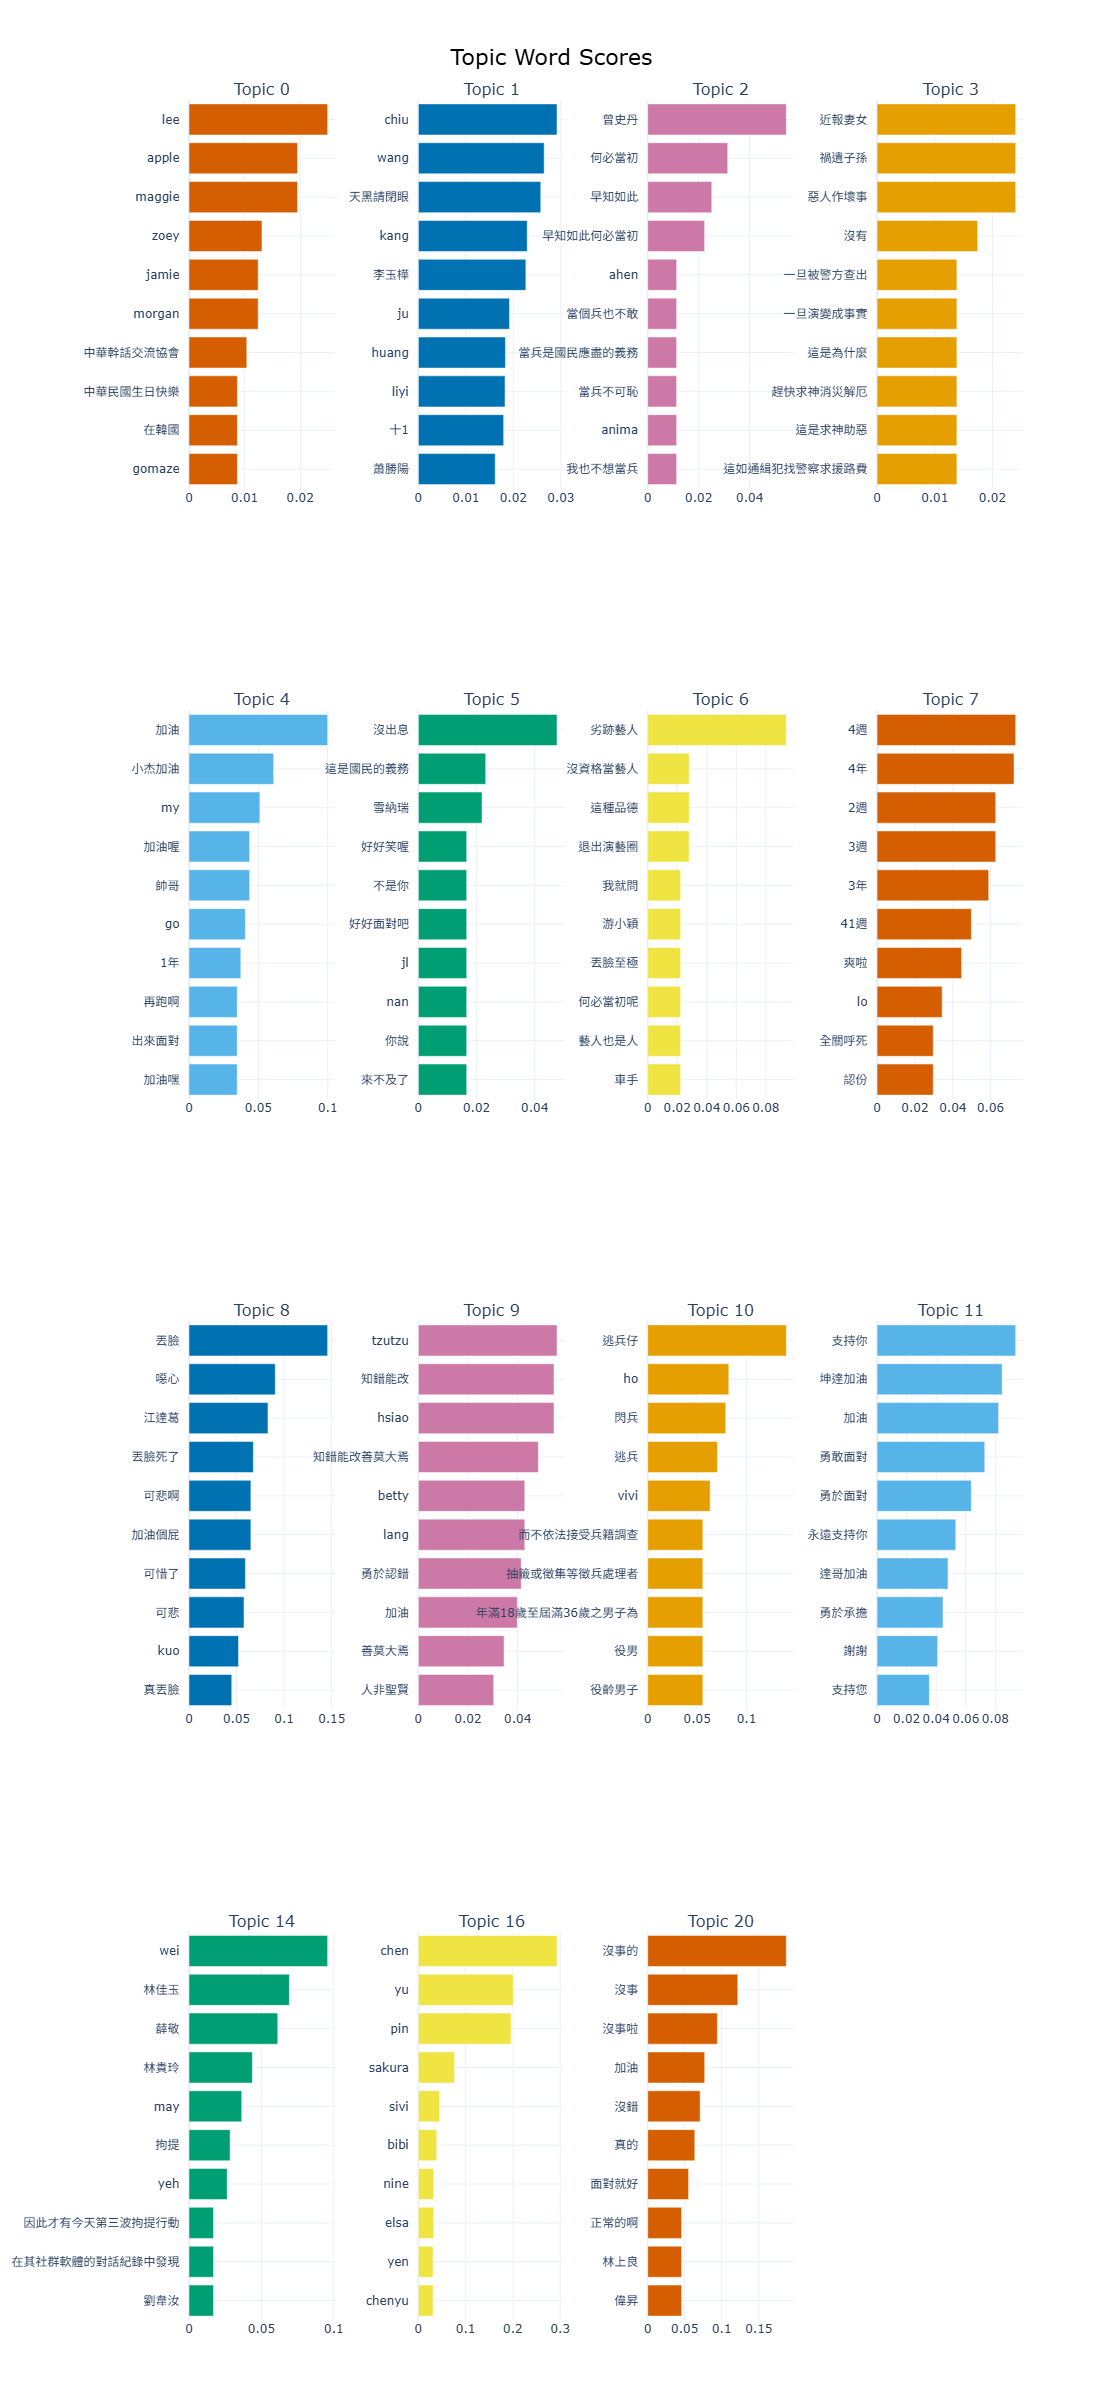

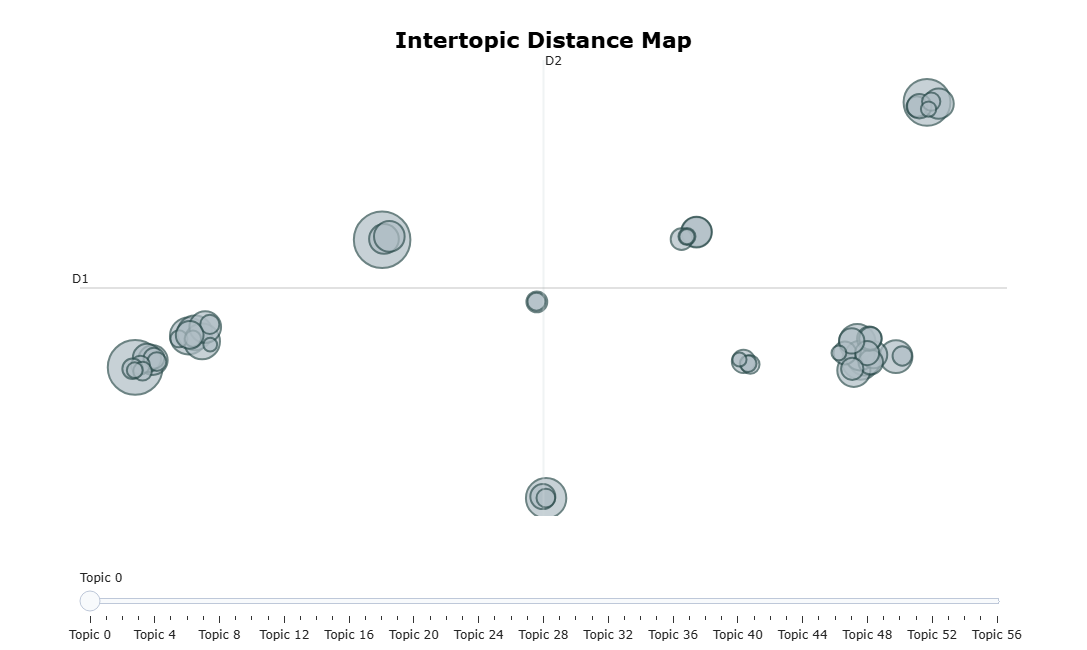

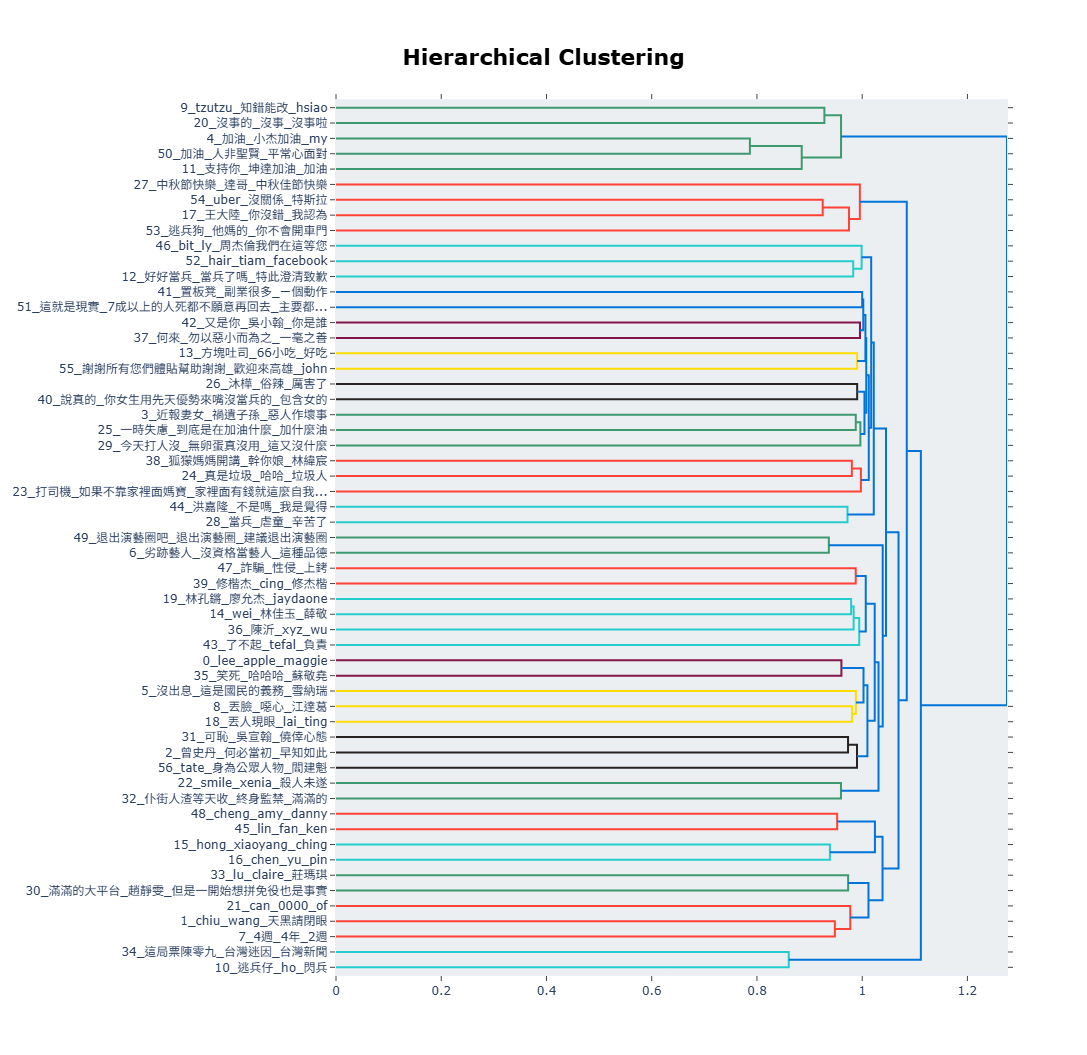

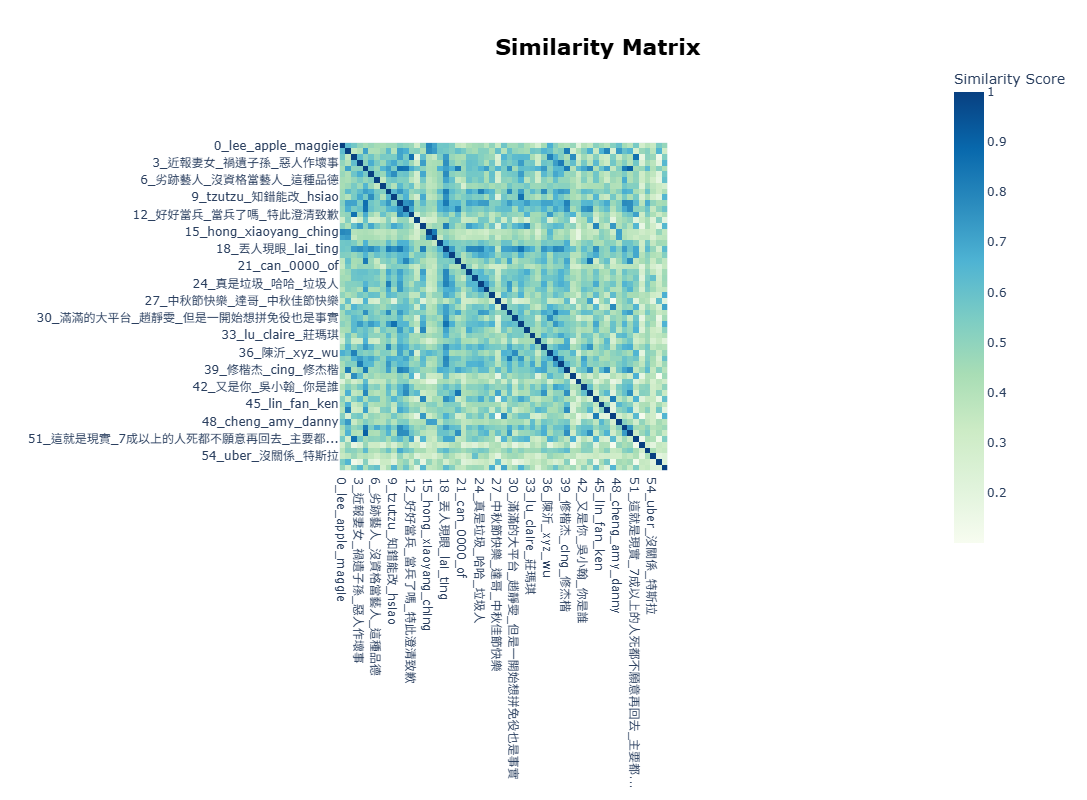

In [29]:
###############
# 圖形化顯示
###############

# top_n_topics: 顯示前幾個主題
# n_words: 每個主題顯示幾個關鍵字
fig1 = topic_model.visualize_barchart(top_n_topics=15, n_words=10, height=600)
fig1.show()

# 儲存為 HTML 檔（可以用瀏覽器開啟，保留互動功能）
fig1.write_html(f"topic_barchart_{platform_name}_overlap.html")

# intertopic distance map
fig2 = topic_model.visualize_topics()
fig2.show()
fig2.write_html(f"topic_distance_map_{platform_name}_overlap.html")

# Hierarchy
fig3 = topic_model.visualize_hierarchy()
fig3.show()
fig3.write_html(f"topic_hierarchy_{platform_name}_overlap.html")

# Heat Map
fig4 = topic_model.visualize_heatmap()
fig4.show()
fig4.write_html(f"topic_heatmap_{platform_name}_overlap.html")